In [ ]:
!pip install torchortho
!uv pip install -q --system numba-cuda==0.4.0 --force-reinstall
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1
config.CUDA_LOW_OCCUPANCY_WARNINGS = 0
from numba import cuda

In [ ]:
import os
import torch
import torch.nn as nn
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import timm
from torch.utils.data import DataLoader, DistributedSampler
from torchortho import HermiteActivation, FourierActivation, TropicalActivation, TropicalRationalActivation
import time


In [ ]:
# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transforms for the dataset
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [ ]:
# Define the model modification
class ModifiedConvNeXtTiny(nn.Module):
    def __init__(self, activation_type=None, pretrained=True, num_classes=10):
        super().__init__()

        # Load pre-trained ConvNeXt-Tiny
        self.model = timm.create_model("convnext_tiny", pretrained=pretrained)

        # Freeze all layers except activation functions and final classifier
        for param in self.model.parameters():
            param.requires_grad = False

        # Modify activations based on the selected type
        if activation_type == "Hermite":
            activation_fn = lambda: HermiteActivation(degree=3, act_init=nn.GELU(), clamp=True)
        elif activation_type == "Fourier":
            activation_fn = lambda: FourierActivation(degree=6, act_init=nn.GELU())
        elif activation_type == "TropicalRational":
            activation_fn = lambda: TropicalRationalActivation(degree=6, act_init=nn.GELU())
        else:
            activation_fn = None  # Keep default activations

        depths=[3,3,9,3]
        if activation_fn:
            for stage in range(4):
                for block in range(depths[stage]):
                    self.model.stages[stage].blocks[block].mlp.act = activation_fn()
                    for param in self.model.stages[stage].blocks[block].mlp.act.parameters():
                        param.requires_grad = True

        # Replace classifier head
        in_features = self.model.head.fc.in_features
        self.model.head.fc = nn.Linear(in_features, num_classes)

        # Make classifier learnable
        for param in self.model.head.fc.parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.model(x)

In [ ]:
# Define a train loop
def train_and_test(model, criterion, optimizer):
  start_time = time.time()
  # Training loop
  num_epochs = 10
  stats_dict = dict(train_loss = [], train_acc = [], test_loss = [], test_acc = [])
  for epoch in range(num_epochs):
      model.train()  # Set model to training mode
      running_loss = 0.0
      correct = 0
      total = 0

      for images, labels in train_loader:
          images = images.to(device)
          labels = labels.to(device)

          optimizer.zero_grad()

          outputs = model(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
          _, predicted = outputs.max(1)
          total += labels.size(0)
          correct += predicted.eq(labels).sum().item()

      train_loss = running_loss / len(train_loader)
      train_acc = 100.0 * correct / total

      # Evaluate on the test set
      model.eval()  # Set model to evaluation mode
      test_loss = 0.0
      correct = 0
      total = 0

      with torch.no_grad():
          for images, labels in test_loader:
              images = images.to(device)
              labels = labels.to(device)

              outputs = model(images)
              loss = criterion(outputs, labels)

              test_loss += loss.item()
              _, predicted = outputs.max(1)
              total += labels.size(0)
              correct += predicted.eq(labels).sum().item()

      test_loss /= len(test_loader)
      test_acc = 100.0 * correct / total

      # Print epoch statistics
      stats_dict['train_loss'].append(train_loss); stats_dict['train_acc'].append(train_acc)
      stats_dict['test_loss'].append(test_loss); stats_dict['test_acc'].append(test_acc)
      print(f'Epoch [{epoch+1}/{num_epochs}]: Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | '
            f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%')

  end_time = time.time()
  elapsed_time = end_time - start_time
  print(f'Elapsed time: {elapsed_time:.2f} (s)')

  return stats_dict

In [ ]:
activation_types = [None, "Hermite", "Fourier", "TropicalRational"]
convnext_tiny_stats={}
for act in activation_types:
    model = ModifiedConvNeXtTiny(activation_type=act).to(device)
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
    # train and test the model
    convnext_tiny_stats[act] = train_and_test(model, criterion, optimizer)

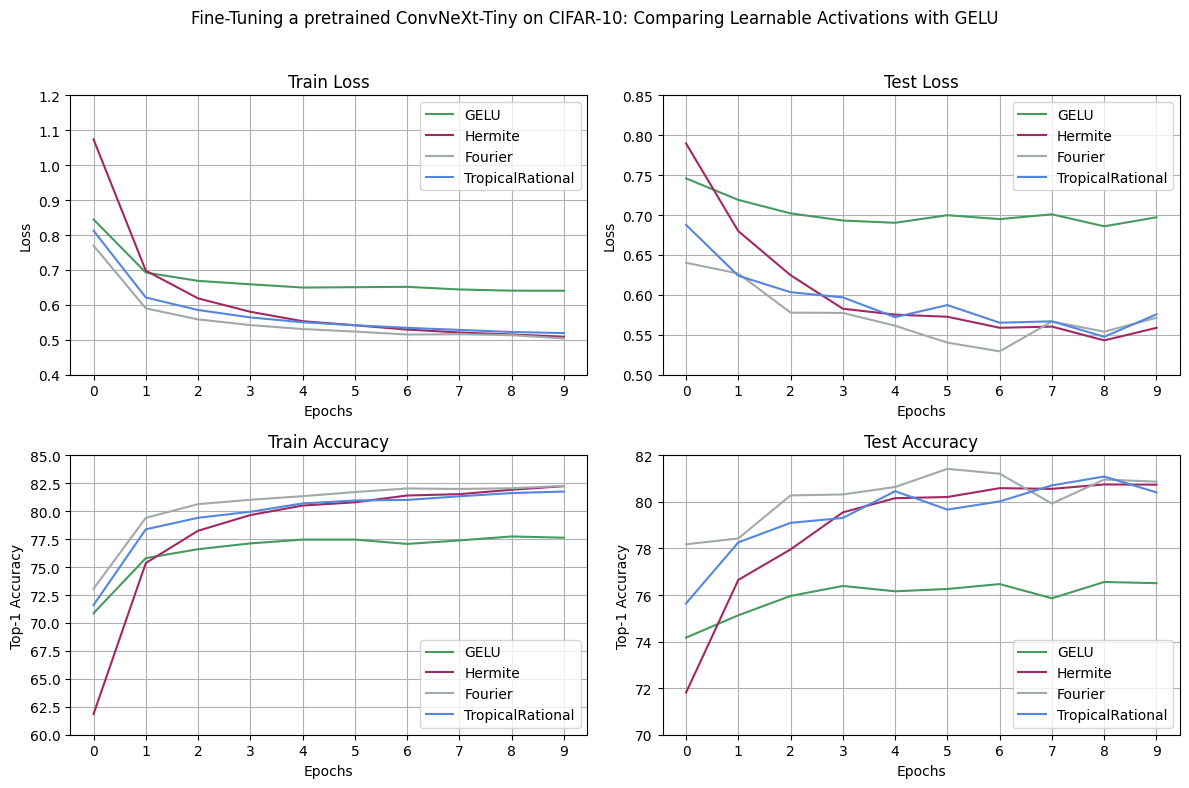

In [ ]:
import matplotlib.pyplot as plt

activation_types = [None, "Hermite", "Fourier", "TropicalRational"]

# Define a color map for consistent colors
color_map = {
    None: '#479A5F',              # Default (GELU)
    'Hermite': '#A12864',
    'Fourier': '#A1A9AD',
    'TropicalRational': '#5387DD'
}

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Fine-Tuning a pretrained ConvNeXt-Tiny on CIFAR-10: Comparing Learnable Activations with GELU')

for act in activation_types:
    label = act or 'GELU'
    color = color_map[act]

    axs[0, 0].plot(convnext_tiny_stats[act]['train_loss'], label=label, color=color)
    axs[0, 0].set_title('Train Loss')

    axs[0, 1].plot(convnext_tiny_stats[act]['test_loss'], label=label, color=color)
    axs[0, 1].set_title('Test Loss')

    axs[1, 0].plot(convnext_tiny_stats[act]['train_acc'], label=label, color=color)
    axs[1, 0].set_title('Train Accuracy')

    axs[1, 1].plot(convnext_tiny_stats[act]['test_acc'], label=label, color=color)
    axs[1, 1].set_title('Test Accuracy')

# Set labels
for ax in axs.flat[:2]:
    ax.set(xlabel='Epochs', ylabel='Loss')

for ax in axs.flat[2:]:
    ax.set(xlabel='Epochs', ylabel='Top-1 Accuracy')

# Add more ticks for better readability
# Use last activation's length as reference (or you can just choose the first one)
ref_length = len(convnext_tiny_stats[activation_types[0]]['train_loss'])
for ax in axs.flat:
    ax.set_xticks(range(0, ref_length, max(1, ref_length // 10)))
    ax.set_yticks(ax.get_yticks())
    ax.legend()
    ax.grid(True)

fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()